# Problem Statement
Metals such as gold have been traded for years across the world. Prices of gold are determined and used 
for trading the metal on commodity exchanges on a daily basis using a variety of factors. Using this daily 
price-level information only, our task is to predict future price of gold


Time series analysis and forecasting have been long studied in detail. There are matured and extensive set of 
modeling techniques available for the same. Out of the many, the following are a few most commonly used 
and explored techniques:
-	 Simple moving average and exponential smoothing based forecasting
-	 Holt’s, Holt-Winter’s Exponential Smoothing based forecasting
-	 Box-Jenkins methodology (AR, MA, ARIMA, S-ARIMA, etc.)

We will focus upon ARIMA models (from the Box-Jenkin’s 
methodology) to forecast gold prices.

Key Concepts
- Stationarity: Stationarity refers to the property where for a time series its mean, 
variance, and autocorrelation are time invariant. In other words, mean, variance, 
and autocorrelation do not change with time. For instance, a time series having 
an upward (or downward) trend is a clear indicator of a non-stationarity because 
its mean would change with time (see web site visit data example in the previous 
section).
- Differencing: One of the methods of stationarizing series. Though there can be other 
transformations, differencing is widely used to stabilize the mean of a time series. We 
simply compute difference between consecutive observations to obtain a differenced 
series. We can then apply different tests to confirm if the resulting series is stationary 
or not. We can also perform second order differencing, seasonal differencing, and so 
on, depending on the time series at hand.
- Unit Root Tests: Statistical tests that help us understand if a given series is stationary 
or not. The Augmented Dickey Fuller test begins with a null hypothesis of series being 
non-stationary, while Kwiatkowski-Phillips-Schmidt-Shin test or KPSS has a null 
hypothesis that the series is stationary. We then perform a regression fit to reject or 
fail to reject the null hypothesis.

# ARIMA

In [1]:
!pip3 install quandl

In [2]:
import quandl
import warnings
import itertools
import numpy as np
import pandas as pd


import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')
sns.set_context('notebook')


from statsmodels.tsa.seasonal import seasonal_decompose


#from arima_utils import ad_fuller_test, plot_rolling_stats
#from arima_utils import plot_acf_pacf, arima_gridsearch_cv

In [3]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

%matplotlib inline
plt.rcParams.update(params)

# specify to ignore warning messages
warnings.filterwarnings("ignore") 

## Getting the Data

In [4]:
df = quandl.get("BUNDESBANK/BBK01_WT5511", end_date="2017-07-31")
print(df.shape)

new_df = df.reindex(pd.date_range(df.index.min(), 
                                  df.index.max(), 
                                  freq='D')).fillna(method='ffill')
print(new_df.shape)
#close_series = new_df.Close

(12152, 1)
(17550, 1)


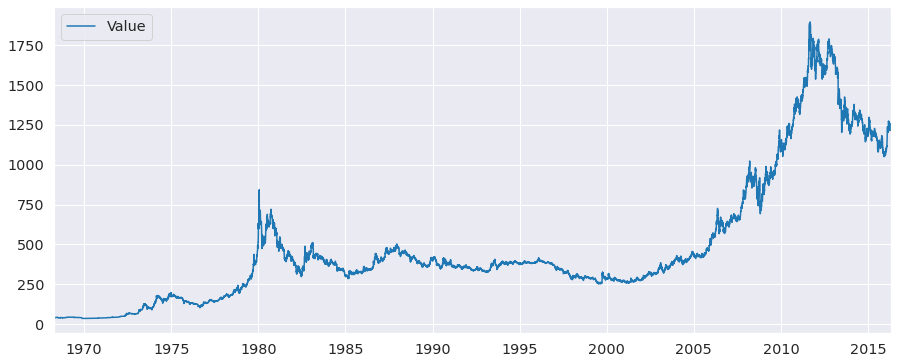

In [5]:
new_df.plot(figsize=(15, 6))
plt.show()

## Decompose
Decompose dataset to visualise Residual, Seasonal & Trend plots

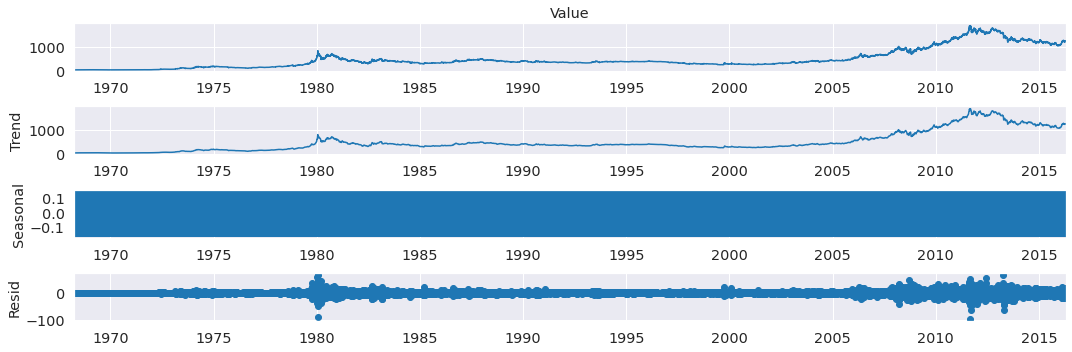

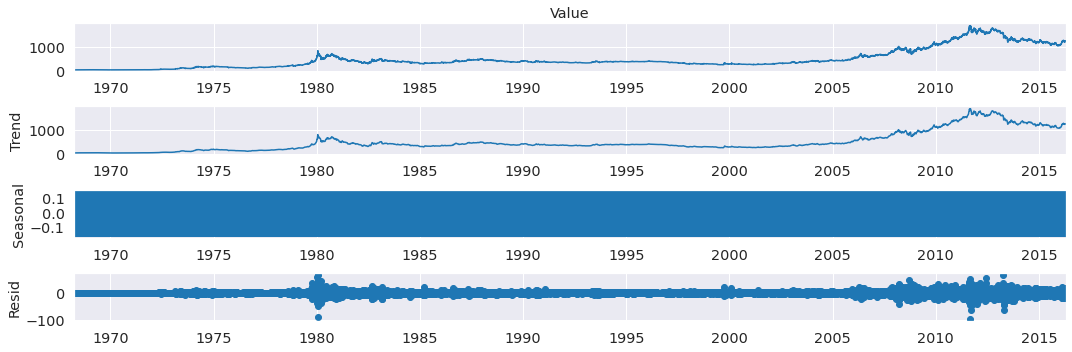

In [6]:
decompose = seasonal_decompose(new_df.Value.interpolate())
decompose.plot()

## Dickey Fuller Test

### Original Series

Lets check the series for stationarity using Dickey Fuller test

In [7]:
import itertools
import numpy as np
import pandas as pd


import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import TimeSeriesSplit

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates



In [8]:
# Dickey Fuller test for Stationarity
def ad_fuller_test(ts):
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value',
                                             '#Lags Used',
                                             'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [9]:
# Plot rolling stats for a time series
def plot_rolling_stats(ts):
    rolling_mean = ts.rolling(window=12,center=False).mean()
    rolling_std = ts.rolling(window=12,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    

In [10]:
## AD Fuller test
ts =new_df.Value
ad_fuller_test(ts)

Test Statistic                    -0.364334
p-value                            0.915886
#Lags Used                        43.000000
Number of Observations Used    17506.000000
Critical Value (1%)               -3.430724
Critical Value (5%)               -2.861705
Critical Value (10%)              -2.566858
dtype: float64


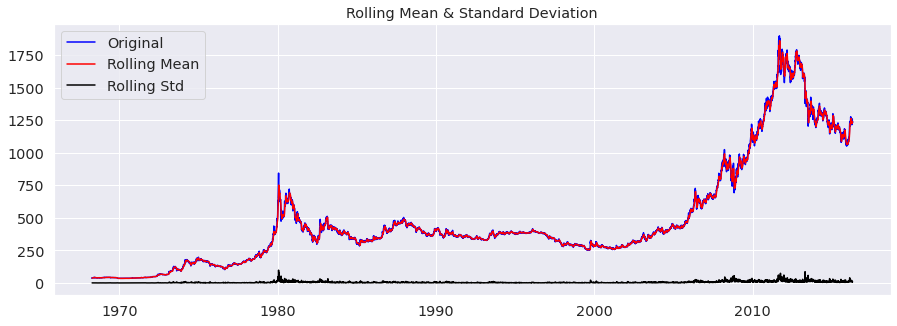

In [11]:
## Plot Rolling Statistics
plot_rolling_stats(ts)

If the test statistic of AD Fuller test is less than the critical value(s), we reject the null hypothesis of non-stationarity. The AD Fuller test is available as part of the statsmodel library. Since it is quite evident that our 
original series of gold prices is non-stationary (Test Statistics -0.3 > critical values), we will perform a log transformation and see if we are able to obtain stationarity.

### Log Series

Test Statistic                    -1.849748
p-value                            0.356057
#Lags Used                        29.000000
Number of Observations Used    17520.000000
Critical Value (1%)               -3.430723
Critical Value (5%)               -2.861705
Critical Value (10%)              -2.566858
dtype: float64


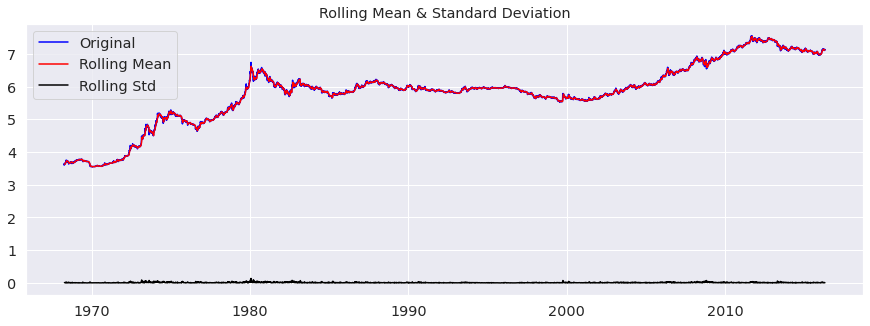

In [12]:
log_series = np.log(ts)

ad_fuller_test(log_series)
## Plot Rolling Statistics
plot_rolling_stats(log_series)

The test statistic of -1.8 is greater than either of critical values, hence we fail to reject the null hypothesis, 
i.e., the series is non-stationary even after log transformation. 

### Log Difference
Lets check if differencing a series helps in achieving stationarity

In [13]:
# Using log series with a shift to make it stationary
log_series_shift = log_series - log_series.shift()
log_series_shift = log_series_shift[~np.isnan(log_series_shift)]

Test Statistic                   -23.917175
p-value                            0.000000
#Lags Used                        28.000000
Number of Observations Used    17520.000000
Critical Value (1%)               -3.430723
Critical Value (5%)               -2.861705
Critical Value (10%)              -2.566858
dtype: float64


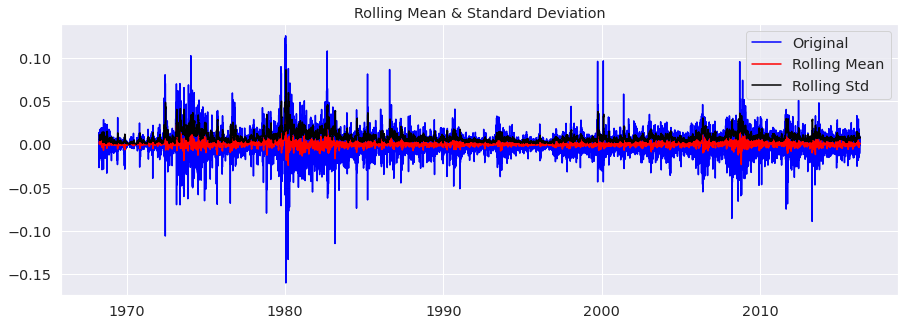

In [14]:
ad_fuller_test(log_series_shift)
plot_rolling_stats(log_series_shift)

The ARIMA model is a logical progression and combination of the two models. Yet if we combine AR 
and MA with a differenced series, what we get is called as ARIMA(p,d,q) model.
where,
- p is the order of Autoregression
- q is the order of Moving average
- d is the order of differencing

Thus, for a stationary time series ARIMA models combine autoregressive and moving average concepts 
to model the behavior of a long running time series and helps in forecasting.


The test statistic at -23.91 is lower than even 1% critical value, thus we reject the null hypothesis for AD 
Fuller test. i.e., the series is stationary after log differenced series. 

We still need to figure out the order of autoregression and moving 
average components, i.e., p and q.

One of the commonly used methods is the plotting of Auto Correlation Function plot(ACF) and Partial Auto Correlation Function plot(PACF) plots to determine p and q values. 

## ACF/ PACF

In [15]:
def plot_acf_pacf(series):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(series.squeeze(), lags=40, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(series, lags=40, ax=ax2)    

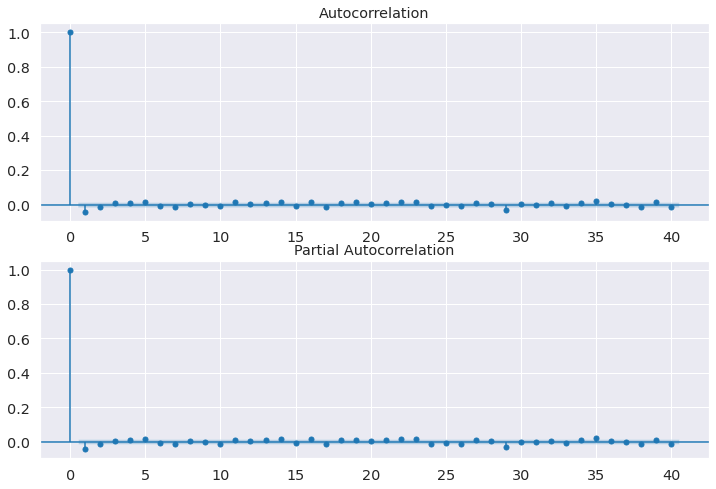

In [16]:
plot_acf_pacf(log_series_shift)

Log Differenced series seems stationary, same is visible through ACF and PACF plots.
Also, the plots show a sudden drop at lag 1 for both ACF and PACF, thus pointing toward 
possible values of q and p to be 1 each, respectively

Another method to derive the p, d, q parameters is to perform a grid search of the parameter space. 
Though statsmodels does not provide such a utility (for obvious reasons though), we can write our own utility to identify the best fitting model. 

## ARIMA

In [17]:
def auto_arima(param_max=1,series=pd.Series(),verbose=True):
    # Define the p, d and q parameters to take any value 
    # between 0 and param_max
    p = d = q = range(0, param_max+1)

    # Generate all different combinations of seasonal p, d and q triplets
    pdq = [(x[0], x[1], x[2]) for x in list(itertools.product(p, d, q))]
    
    model_resuls = []
    best_model = {}
    min_aic = 10000000
    for param in pdq:
        try:
            mod = sm.tsa.ARIMA(series, order=param)

            results = mod.fit()
            
            if verbose:
                print('ARIMA{}- AIC:{}'.format(param, results.aic))
            model_resuls.append({'aic':results.aic,
                                 'params':param,
                                 'model_obj':results})
            if min_aic>results.aic:
                best_model={'aic':results.aic,
                            'params':param,
                            'model_obj':results}
                min_aic = results.aic
        except Exception as ex:
            print(ex)
    if verbose:
        print("Best Model params:{} AIC:{}".format(best_model['params'],
              best_model['aic']))  
        
    return best_model, model_resuls

In [18]:
def arima_gridsearch_cv(series, cv_splits=2,verbose=True,show_plots=True):
    # prepare train-test split object
    tscv = TimeSeriesSplit(n_splits=cv_splits)
    
    # initialize variables
    splits = []
    best_models = []
    all_models = []
    i = 1
    
    # loop through each CV split
    for train_index, test_index in tscv.split(series):
        print("*"*20)
        print("Iteration {} of {}".format(i,cv_splits))
        i = i + 1
        
        # print train and test indices
        if verbose:
            print("TRAIN:", train_index, "TEST:", test_index)
        splits.append({'train':train_index,'test':test_index})
        
        # split train and test sets
        train_series = series.iloc[train_index]
        test_series = series.iloc[test_index]
        
        print("Train shape:{}, Test shape:{}".format(train_series.shape,
              test_series.shape))
        
        # perform auto arima
        _best_model, _all_models = auto_arima(series=train_series)
        best_models.append(_best_model)
        all_models.append(_all_models)
        
        # display summary for best fitting model
        if verbose:
            print(_best_model['model_obj'].summary())
        results = _best_model['model_obj']
        
        if show_plots:
            # show residual plots
            residuals = pd.DataFrame(results.resid)
            residuals.plot()
            plt.title('Residual Plot')
            plt.show()
            residuals.plot(kind='kde')
            plt.title('KDE Plot')
            plt.show()
            print(residuals.describe())
        
            # show forecast plot
            fig, ax = plt.subplots(figsize=(18, 4))
            fig.autofmt_xdate()
            ax = train_series.plot(ax=ax)
            test_series.plot(ax=ax)
            fig = results.plot_predict(test_series.index.min(), 
                                       test_series.index.max(), 
                                       dynamic=True,ax=ax,
                                       plot_insample=False)
            plt.title('Forecast Plot ')
            plt.legend()
            plt.show()

            # show error plot
            
            insample_fit = list(results.predict(train_series.index.min()+pd.Timedelta(days=1), 
                                                train_series.index.max(),
                                                typ='levels')) 
            plt.plot((np.exp(train_series.iloc[1:].tolist())-\
                             np.exp(insample_fit)))
            plt.title('Error Plot')
            plt.show()
    return {'cv_split_index':splits,
            'all_models':all_models,
            'best_models':best_models}

In [19]:
new_df['log_series'] = log_series
new_df['log_series_shift'] = log_series_shift

### Training-Testing Split

Note that we are passing the log transformed series as input to the arima_gridsearch_cv() function. 
As we saw earlier, the log differenced series was what helped us achieve stationarity, hence we use the log 
transformation as our starting point and fit an ARIMA model with d set to 1. The function call generates 
a detailed output for each train-test split (we have five of them lined up), each iteration performing a grid 
search over p, d, and q. Figure 11-9 shows the output of the first iteration, where the training set included 
only 2924 observations

********************
Iteration 1 of 5
TRAIN: [   0    1    2 ... 2922 2923 2924] TEST: [2925 2926 2927 ... 5847 5848 5849]
Train shape:(2925,), Test shape:(2925,)
ARIMA(0, 0, 0)- AIC:5358.675881541096
ARIMA(0, 0, 1)- AIC:1370.644173716165
ARIMA(0, 1, 0)- AIC:-17795.53995335306
ARIMA(0, 1, 1)- AIC:-17793.564973634653
ARIMA(1, 0, 0)- AIC:-17788.09838874002
ARIMA(1, 0, 1)- AIC:-17786.104194993866
ARIMA(1, 1, 0)- AIC:-17793.562143972755
ARIMA(1, 1, 1)- AIC:-17794.157105710285
Best Model params:(0, 1, 0) AIC:-17795.53995335306
                             ARIMA Model Results                              
Dep. Variable:           D.log_series   No. Observations:                 2924
Model:                 ARIMA(0, 1, 0)   Log Likelihood                8899.770
Method:                           css   S.D. of innovations              0.012
Date:                Mon, 26 Apr 2021   AIC                         -17795.540
Time:                        19:20:49   BIC                         -17783.57

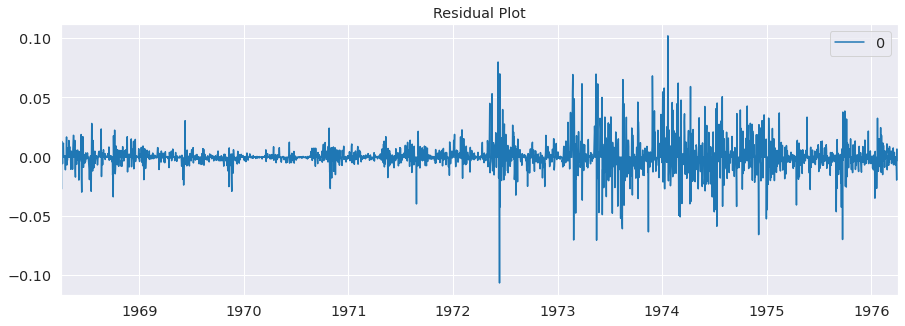

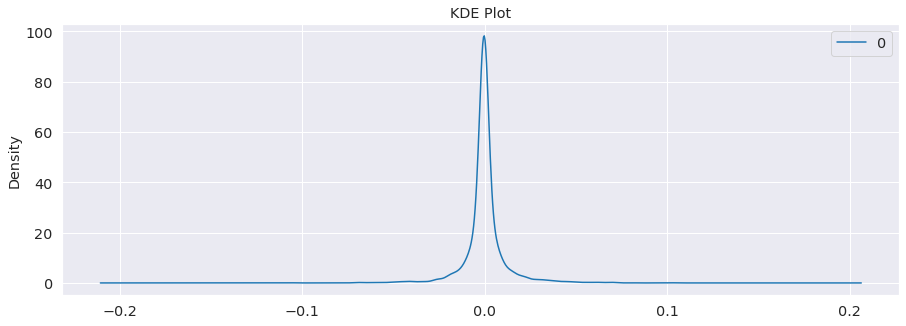

                  0
count  2.924000e+03
mean   4.121924e-10
std    1.153390e-02
min   -1.064569e-01
25%   -1.937840e-03
50%   -4.186598e-04
75%    1.343455e-03
max    1.020067e-01


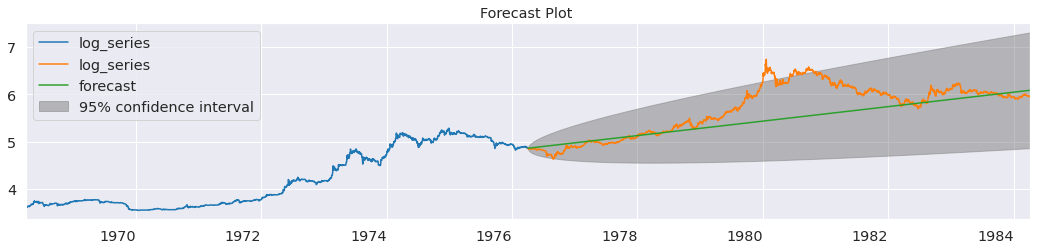

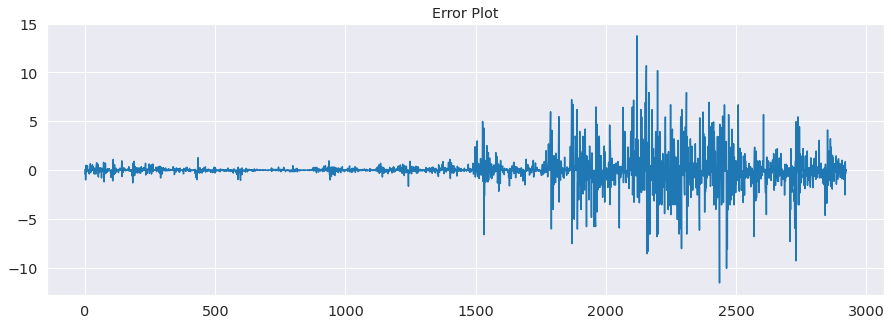

********************
Iteration 2 of 5
TRAIN: [   0    1    2 ... 5847 5848 5849] TEST: [5850 5851 5852 ... 8772 8773 8774]
Train shape:(5850,), Test shape:(2925,)
ARIMA(0, 0, 0)- AIC:15792.660349788817
ARIMA(0, 0, 1)- AIC:7814.0970964599055
ARIMA(0, 1, 0)- AIC:-33512.28307448926
ARIMA(0, 1, 1)- AIC:-33516.96483490087
ARIMA(1, 0, 0)- AIC:-33502.69898057054
ARIMA(1, 0, 1)- AIC:-33507.007684240976
ARIMA(1, 1, 0)- AIC:-33516.56690977644
ARIMA(1, 1, 1)- AIC:-33517.287138254076
Best Model params:(1, 1, 1) AIC:-33517.287138254076
                             ARIMA Model Results                              
Dep. Variable:           D.log_series   No. Observations:                 5849
Model:                 ARIMA(1, 1, 1)   Log Likelihood               16762.644
Method:                       css-mle   S.D. of innovations              0.014
Date:                Mon, 26 Apr 2021   AIC                         -33517.287
Time:                        19:20:52   BIC                         -33490.5

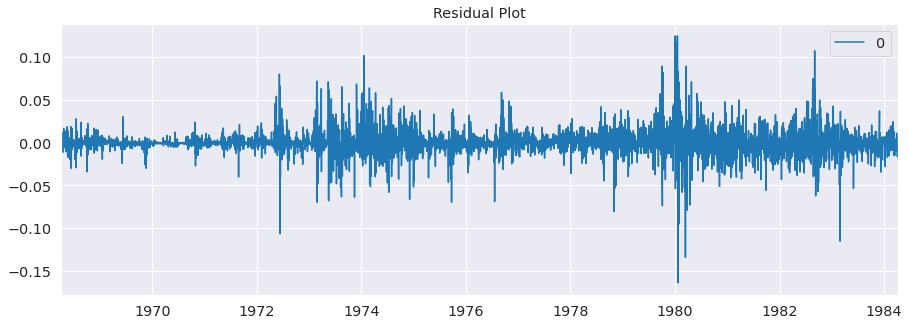

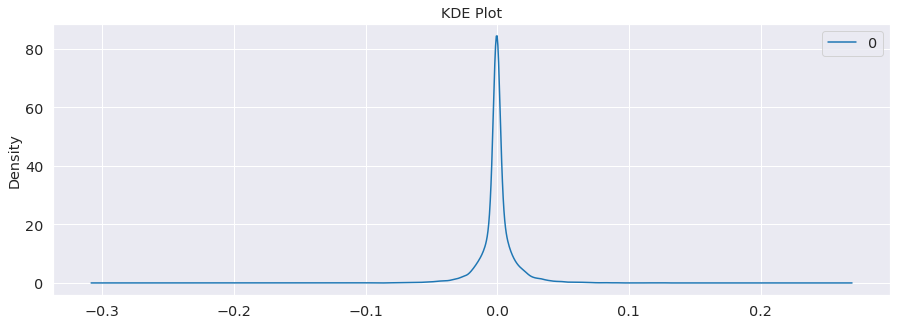

                  0
count  5.849000e+03
mean  -1.225620e-07
std    1.377704e-02
min   -1.640484e-01
25%   -2.716840e-03
50%   -4.121953e-04
75%    2.374839e-03
max    1.249846e-01


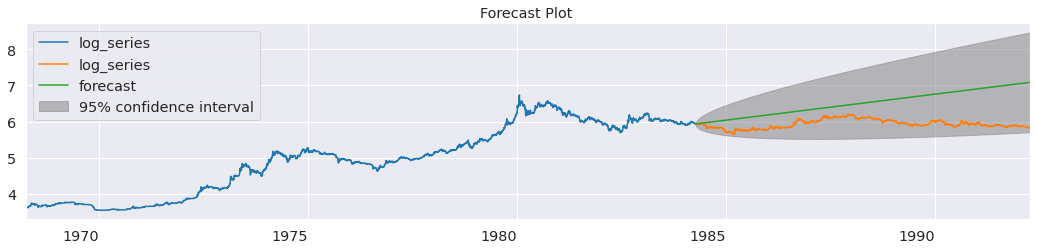

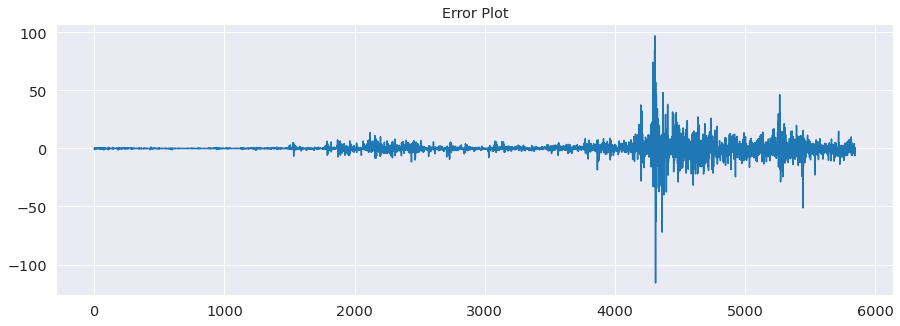

********************
Iteration 3 of 5
TRAIN: [   0    1    2 ... 8772 8773 8774] TEST: [ 8775  8776  8777 ... 11697 11698 11699]
Train shape:(8775,), Test shape:(2925,)
ARIMA(0, 0, 0)- AIC:22924.70092833443
ARIMA(0, 0, 1)- AIC:10939.921256251488
ARIMA(0, 1, 0)- AIC:-52348.46895881139
ARIMA(0, 1, 1)- AIC:-52365.886422161435
ARIMA(1, 0, 0)- AIC:-52340.135707645124
ARIMA(1, 0, 1)- AIC:-52357.13694273647
ARIMA(1, 1, 0)- AIC:-52364.9954035126
ARIMA(1, 1, 1)- AIC:-52366.21248653052
Best Model params:(1, 1, 1) AIC:-52366.21248653052
                             ARIMA Model Results                              
Dep. Variable:           D.log_series   No. Observations:                 8774
Model:                 ARIMA(1, 1, 1)   Log Likelihood               26187.106
Method:                       css-mle   S.D. of innovations              0.012
Date:                Mon, 26 Apr 2021   AIC                         -52366.212
Time:                        19:20:57   BIC                         -5233

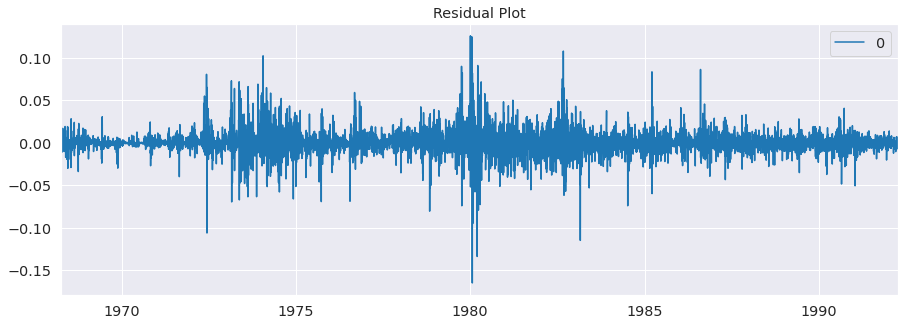

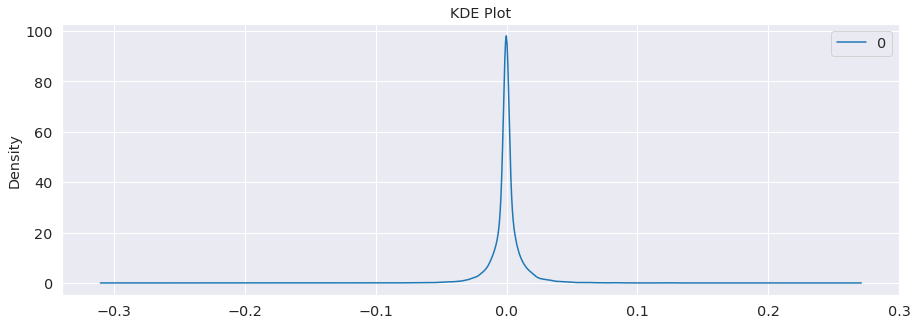

                  0
count  8.774000e+03
mean  -8.569184e-08
std    1.223435e-02
min   -1.650598e-01
25%   -2.567134e-03
50%   -2.630365e-04
75%    2.402581e-03
max    1.256747e-01


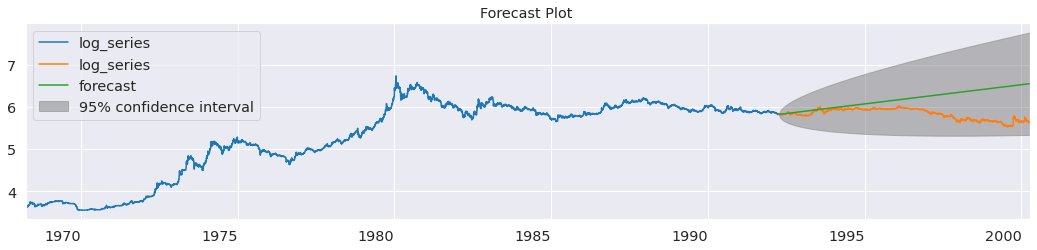

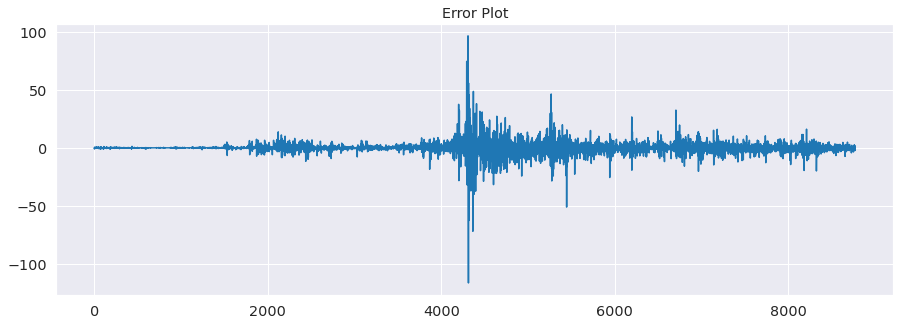

********************
Iteration 4 of 5
TRAIN: [    0     1     2 ... 11697 11698 11699] TEST: [11700 11701 11702 ... 14622 14623 14624]
Train shape:(11700,), Test shape:(2925,)
ARIMA(0, 0, 0)- AIC:28323.593243498864
ARIMA(0, 0, 1)- AIC:12343.352798126161
ARIMA(0, 1, 0)- AIC:-72092.36827299207
ARIMA(0, 1, 1)- AIC:-72119.82137921192
ARIMA(1, 0, 0)- AIC:-72085.08760833612
ARIMA(1, 0, 1)- AIC:-72112.18893154824
ARIMA(1, 1, 0)- AIC:-72118.75588542139
ARIMA(1, 1, 1)- AIC:-72119.86496021537
Best Model params:(1, 1, 1) AIC:-72119.86496021537
                             ARIMA Model Results                              
Dep. Variable:           D.log_series   No. Observations:                11699
Model:                 ARIMA(1, 1, 1)   Log Likelihood               36063.932
Method:                       css-mle   S.D. of innovations              0.011
Date:                Mon, 26 Apr 2021   AIC                         -72119.865
Time:                        19:21:05   BIC                       

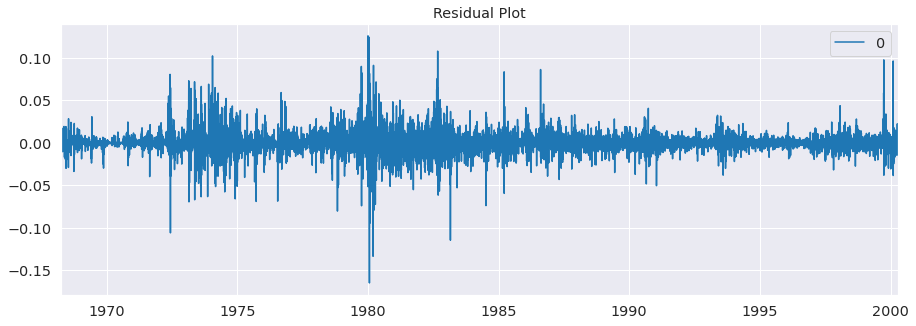

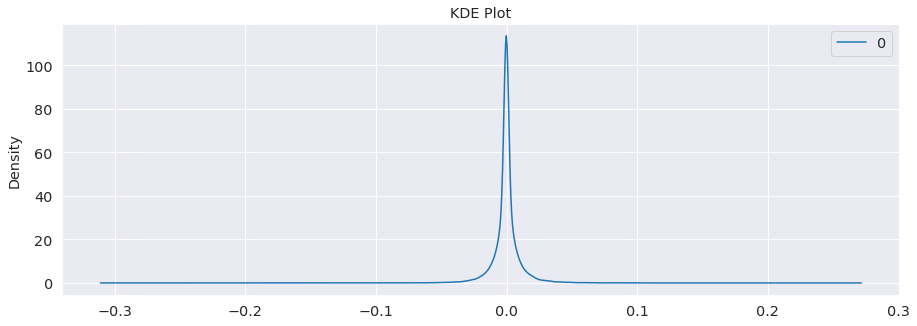

                  0
count  1.169900e+04
mean  -6.266552e-08
std    1.109183e-02
min   -1.652706e-01
25%   -2.322448e-03
50%   -1.811519e-04
75%    2.032720e-03
max    1.259057e-01


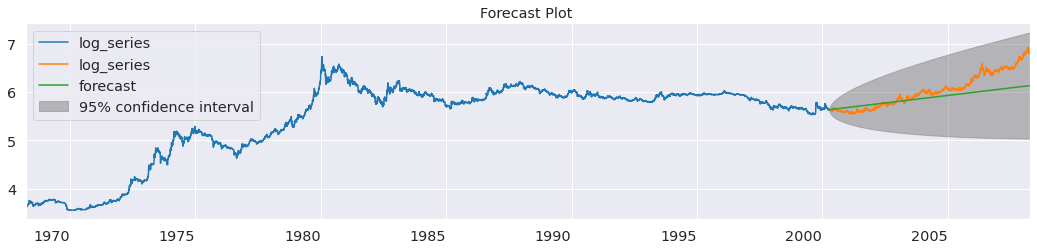

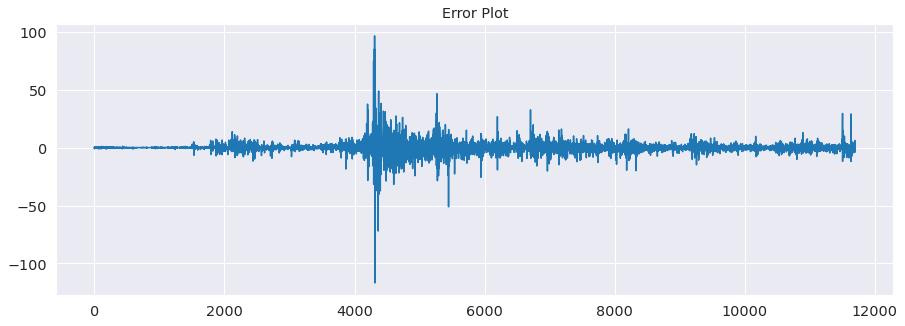

********************
Iteration 5 of 5
TRAIN: [    0     1     2 ... 14622 14623 14624] TEST: [14625 14626 14627 ... 17547 17548 17549]
Train shape:(14625,), Test shape:(2925,)
ARIMA(0, 0, 0)- AIC:34336.88986620506
ARIMA(0, 0, 1)- AIC:14355.652400375799
ARIMA(0, 1, 0)- AIC:-91312.75496091215
ARIMA(0, 1, 1)- AIC:-91348.77150649155
ARIMA(1, 0, 0)- AIC:-91301.13184743936
ARIMA(1, 0, 1)- AIC:-91336.41118491752
ARIMA(1, 1, 0)- AIC:-91347.65810577202
ARIMA(1, 1, 1)- AIC:-91348.29945381288
Best Model params:(0, 1, 1) AIC:-91348.77150649155
                             ARIMA Model Results                              
Dep. Variable:           D.log_series   No. Observations:                14624
Model:                 ARIMA(0, 1, 1)   Log Likelihood               45677.386
Method:                       css-mle   S.D. of innovations              0.011
Date:                Mon, 26 Apr 2021   AIC                         -91348.772
Time:                        19:21:20   BIC                        

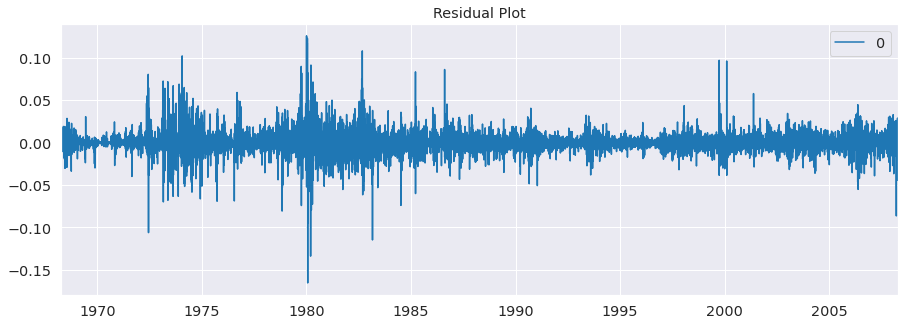

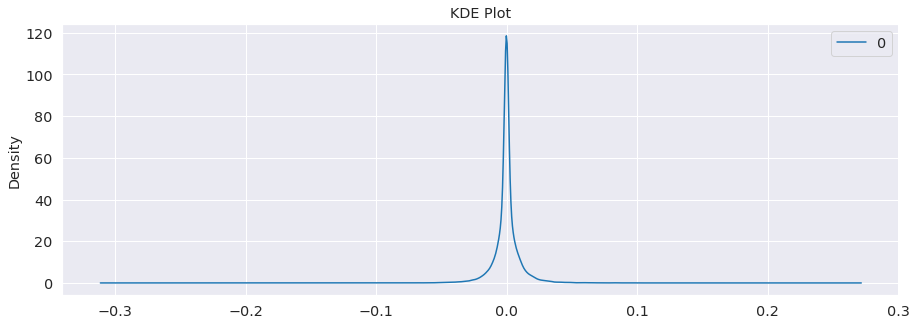

                  0
count  1.462400e+04
mean  -3.472316e-08
std    1.064827e-02
min   -1.656143e-01
25%   -2.387170e-03
50%   -2.301705e-04
75%    2.207818e-03
max    1.258538e-01


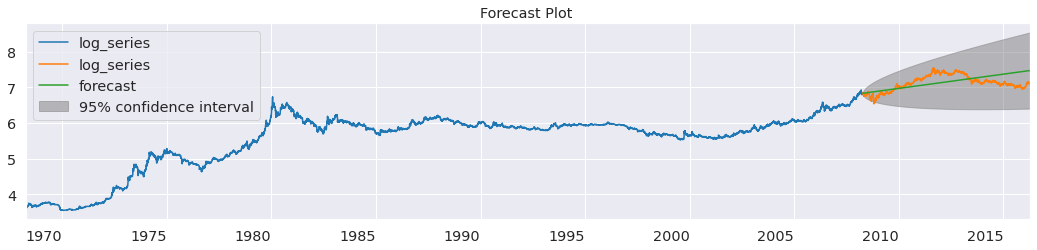

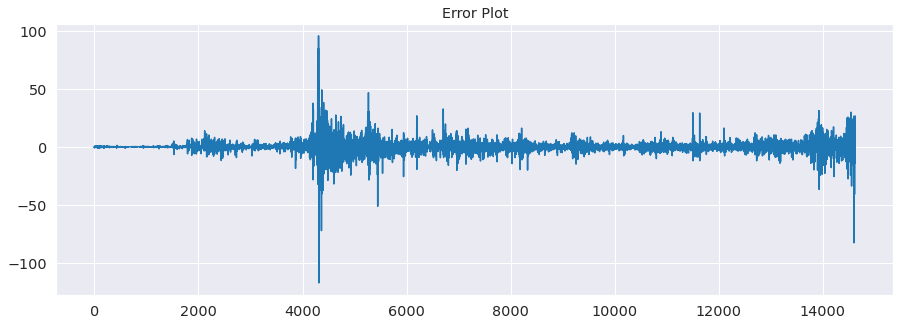

In [20]:
results_dict = arima_gridsearch_cv(new_df.log_series,cv_splits=5)

In this case, we generated forecast for time periods for which we already had data. This helps us in 
visualizing and understanding how the model is performing. This is also called as back testing. ~